In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('diabetes.txt', sep = " ")
data.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135


In [3]:
# Define X and Y arrays
X = data.iloc[:,:data.shape[1]-1]
Y = data.iloc[:,data.shape[1]-1].to_numpy()

In [4]:
# We center the Y
Y_tilde = Y - Y.mean(axis=0)

In [5]:
def Gibbs_sampler_bayesian_elastic_net(n_iter, lambda1, lambda2, a, b):

    N, p = X.shape

    # ----- Initialization -----
    beta = [np.random.uniform(size=p)]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size=p)]

    XtX = X.T @ X
    XtY = X.T @ Y_tilde

    for i in range(n_iter):

        # =========================
        # 1️⃣ Sample beta
        # =========================
        D_tau_inv = np.diag(1 / tau_sq[i])

        A = D_tau_inv + XtX + lambda2 * np.eye(p)
        A_inv = np.linalg.inv(A)

        mean_beta = A_inv @ XtY
        cov_beta = sigma_sq[i] * A_inv

        beta_new = np.random.multivariate_normal(mean_beta, cov_beta)
        beta.append(beta_new)

        # =========================
        # 2️⃣ Sample sigma_sq
        # =========================
        resid = Y_tilde - X @ beta_new

        shape = N/2 + p/2 + a

        scale = (
            resid.T @ resid / 2
            + lambda1 * beta_new.T @ D_tau_inv @ beta_new / 2
            + lambda2 * beta_new.T @ beta_new / 2
            + b
        )

        sigma_sq_new = sc.invgamma.rvs(a=shape, scale=scale)
        sigma_sq.append(sigma_sq_new)

        # =========================
        # 3️⃣ Sample tau_sq
        # =========================
        # Inverse Gaussian mixture (same structure as Bayesian Lasso)

        mean_tau = np.sqrt(lambda1**2 * sigma_sq_new / (beta_new**2 + 1e-12))
        scale_tau = lambda1**2

        tau_sq_new = 1 / np.random.wald(mean_tau, scale_tau)
        tau_sq.append(tau_sq_new)

    return beta[int(n_iter/2):], sigma_sq[int(n_iter/2):], tau_sq[int(n_iter/2):]


In [6]:
def posterior_median_beta(beta_samples):
    beta_array = np.array(beta_samples)
    return np.median(beta_array, axis=0)


In [7]:
def calc_min_interval(x, alpha):

    n = len(x)
    cred_mass = 1.0 - alpha

    interval_idx_inc = int(np.floor(cred_mass * n))
    n_intervals = n - interval_idx_inc

    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    min_idx = np.argmin(interval_width)

    hdi_min = x[min_idx]
    hdi_max = x[min_idx + interval_idx_inc]

    return hdi_max, hdi_min


In [8]:
n_iter = 10000

lambda1 = 1.0      # L1 shrinkage
lambda2 = 1.0      # L2 shrinkage

a = 1e-3
b = 1e-3


In [9]:
beta_samples, sigma_samples, tau_samples = Gibbs_sampler_bayesian_elastic_net(
    n_iter,
    lambda1,
    lambda2,
    a,
    b
)


In [10]:
beta_median = posterior_median_beta(beta_samples)


In [11]:
coef_sample = []

beta_array = np.array(beta_samples)

for j in range(X.shape[1]):
    coef_sample.append(beta_array[:, j])

confint_ = []

for j in range(X.shape[1]):
    confint_.append(
        calc_min_interval(np.sort(coef_sample[j]), 0.05)
    )


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV


In [13]:
elastic_cv = ElasticNetCV(
    l1_ratio=np.linspace(0.1, 0.9, 9),
    alphas=np.logspace(-4, 2, 100),
    cv=5,
    max_iter=10000
)

elastic_cv.fit(X, Y_tilde)

elastic_coef = elastic_cv.coef_



In [14]:
ci_min = np.array([i[0] for i in confint_])
ci_max = np.array([i[1] for i in confint_])


In [15]:
variables = [f"X{i}" for i in range(X.shape[1])]

df_plot = pd.DataFrame({
    "Variable": variables,
    "ElasticNet_sklearn": elastic_coef,
    "Bayesian_EN": beta_median,
    "CI_min": ci_min,
    "CI_max": ci_max
})


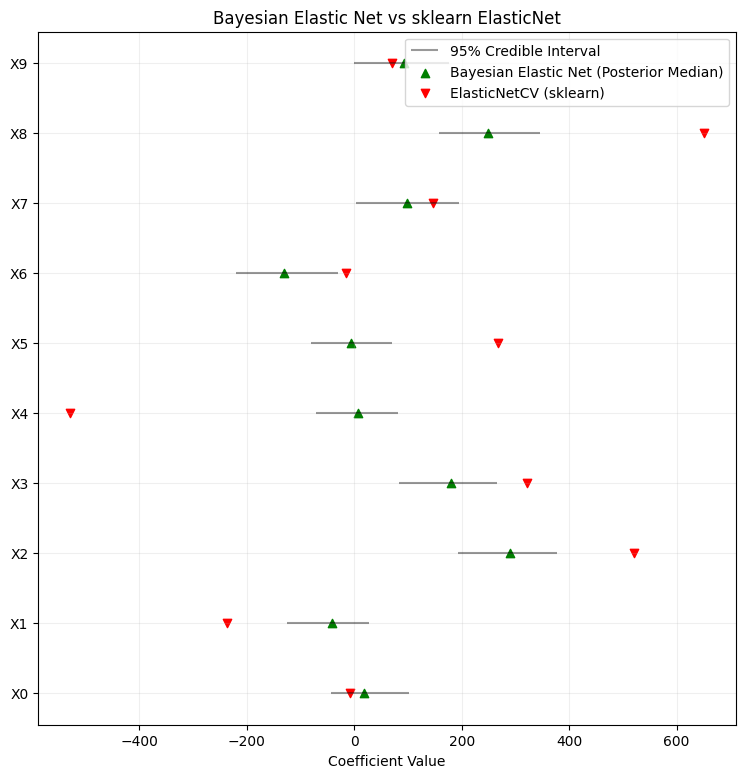

In [16]:
y_pos = np.arange(len(df_plot))

plt.figure(figsize=(9,9))

# Credible Intervals
plt.hlines(
    y=y_pos,
    xmin=df_plot["CI_min"],
    xmax=df_plot["CI_max"],
    color='black',
    alpha=0.4,
    label='95% Credible Interval'
)

# Bayesian Elastic Net Posterior Median
plt.scatter(
    df_plot["Bayesian_EN"],
    y_pos,
    color='green',
    marker='^',
    label='Bayesian Elastic Net (Posterior Median)'
)

# sklearn Elastic Net
plt.scatter(
    df_plot["ElasticNet_sklearn"],
    y_pos,
    color='red',
    marker='v',
    label='ElasticNetCV (sklearn)'
)

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Coefficient Value")
plt.title("Bayesian Elastic Net vs sklearn ElasticNet")
plt.legend()
plt.grid(alpha=0.2)

plt.show()
